# Getting Started

## Imports

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import contractions
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, QuantileTransformer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Load

In [2]:
df_train = pd.read_csv('data/df_train_prepped.csv')
df_test = pd.read_csv('data/df_test_prepped.csv', )

## Column Names - STATIC

I prefer standardizing column names:

In [3]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
TEXT_TOKENIZED = 'Text Tokenized'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
_LOC_POINT = '_loc_point'
WORDS_PER_TWEET = 'Words Per Tweet'
CHAR_PER_TWEET = 'Characters Per Tweet'
LOCATIONS = 'Locations'
_LOC_SPACY_OBJ_ = 'Location Spacy Object'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'
IN_BOW = 'Present In BOW'

In [4]:
df_train.isna().sum()

id                                  0
keyword                            61
location                         2533
text                                0
target                              0
Punctuation Count Per Tweet         0
Number in Tweet                     0
Sentiment Score                     0
Sentiment Score (rounded off)       0
Text Tokenized                      0
Words Per Tweet                     0
Characters Per Tweet                0
Present In BOW                      0
Locations                           0
Identifiable Location               0
all_text                            0
all_text_joined                     0
dtype: int64

In [5]:
df_test.isna().sum()

id                                  0
keyword                            26
location                         1105
text                                1
Punctuation Count Per Tweet         0
Number in Tweet                     0
Sentiment Score                     0
Sentiment Score (rounded off)       0
Locations                           0
Identifiable Location               0
Text Tokenized                      0
Words Per Tweet                     0
Characters Per Tweet                0
Present In BOW                      0
all_text                            0
all_text_joined                     1
dtype: int64

In [6]:
df_test.fillna(' ', inplace=True)
df_test.isna().sum()

id                               0
keyword                          0
location                         0
text                             0
Punctuation Count Per Tweet      0
Number in Tweet                  0
Sentiment Score                  0
Sentiment Score (rounded off)    0
Locations                        0
Identifiable Location            0
Text Tokenized                   0
Words Per Tweet                  0
Characters Per Tweet             0
Present In BOW                   0
all_text                         0
all_text_joined                  0
dtype: int64

# Building a Data Modeling Pipeline

## Helper Functions

In [7]:
def print_classification_metrics(y_train, train_pred, y_test, test_pred):
    print('Training Accuracy: ', accuracy_score(y_train, train_pred))
    print('Training f1-score: ', f1_score(y_train, train_pred))
    print('Accuracy: ', accuracy_score(y_test, test_pred))
    print('Precision: ', precision_score(y_test, test_pred))
    print('Recall: ', recall_score(y_test, test_pred))
    print('f1-score: ', f1_score(y_test, test_pred))
    
def predict_challenge_test_data(model, test_data, filename):
    submission_predictions = model.predict(test_data)
    df_submission = pd.read_csv('data/sample_submission.csv')
    df_submission[TARGET] = submission_predictions
    df_submission.to_csv(filename, index=False)

In [8]:
DF_PERF_METRICS = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs)'
])
LIST_MODELS_TRAINED = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train_sparse, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test_sparse)
    # Add to ith row of dataframe - metrics
    DF_PERF_METRICS.loc[i] = [
        model_name,
        model.score(X_train_sparse, y_train),
        model.score(X_test_sparse, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    LIST_MODELS_TRAINED.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

## Baseline 

I have chosen to use only the joined text data, transformed using CountVectorizer and normalised using TfIdf Transformer. Logistic Regression is used for model training.

In [9]:
cols_to_train = [ALL_TEXT_JOINED]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

pipe = Pipeline([('count_vec', CountVectorizer(ngram_range=(1, 2))),
                 ('tf_idf', TfidfTransformer(smooth_idf=False))])
ct = ColumnTransformer([('pipe', pipe, ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [10]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_sparse, y_train)
baseline_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [11]:
print_classification_metrics(y_train, training_prediction, y_test, baseline_prediction)

Training Accuracy:  0.9185550082101807
Training f1-score:  0.8972659486329743
Accuracy:  0.8003939592908733
Precision:  0.8176795580110497
Recall:  0.6841294298921418
f1-score:  0.7449664429530202


In [12]:
model = log_reg.fit(ct.transform(df_train[cols_to_train]), df_train[TARGET].values)
predict_challenge_test_data(model, df_test_sparse, 'Predictions/baseline_predictions_1.csv')

**Observations**

The training accuracy and f1-score is quite high as compared to the test (hold-out) accuracy.

## Testing Performance with CountVectorizer

Now, testing the performance without normalization using TfidfTransformer.

In [13]:
cols_to_train = [ALL_TEXT_JOINED]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec', CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [14]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [15]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9885057471264368
Training f1-score:  0.9865591397849462
Accuracy:  0.8017071569271176
Precision:  0.8070796460176991
Recall:  0.7026194144838213
f1-score:  0.7512355848434925


**Observations**

There is improvement in the performance. Hence, I will continue to use only CountVectorizer.

In [16]:
model = log_reg.fit(ct.transform(df_train[cols_to_train]), df_train[TARGET].values)
predict_challenge_test_data(model, df_test_sparse, 'Predictions/test_predictions_1.csv')

## Adding Sentiment

In [17]:
# TEST 1 - Using Rounded off Sentiment Score

cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec', CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [18]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [19]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9886699507389163
Training f1-score:  0.9867536955269726
Accuracy:  0.8003939592908733
Precision:  0.8074866310160428
Recall:  0.6979969183359014
f1-score:  0.7487603305785123


In [20]:
# TEST 2 - Using Raw Sentiment Score

cols_to_train = [ALL_TEXT_JOINED, SENTIMENT]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

ct = ColumnTransformer([('count_vec', CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [21]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [22]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9886699507389163
Training f1-score:  0.9867536955269726
Accuracy:  0.7971109652002626
Precision:  0.7992957746478874
Recall:  0.699537750385208
f1-score:  0.7460969597370584


## Adding Other Features

Removed **characters per tweet** since it is strongly correlated with **words per tweet**. So, it doesn't make sense that I keep both.

In [23]:
# TEST 1

cols_to_train = [
    ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET,
    NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION, IN_BOW
] # avg ~ 74

# # TEST 2

# cols_to_train = [
#     ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET,
#     NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION
# ] # avg ~ 76

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

cols_to_scale = [WORDS_PER_TWEET, PUNCTUATION_COUNT]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ('count_vec', CountVectorizer(ngram_range=(1, 2)) , ALL_TEXT_JOINED)],
    remainder='passthrough')

In [24]:
ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [25]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
test_prediction = log_reg.predict(X_test_sparse)
training_prediction = log_reg.predict(X_train_sparse)

In [26]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.9873563218390805
Training f1-score:  0.9851894595114447
Accuracy:  0.799080761654629
Precision:  0.7941680960548885
Recall:  0.7134052388289677
f1-score:  0.7516233766233767


**Observations**

The model performance decreases on adding all the features.

## Feature Importance using Random Forest 

In [27]:
cols_to_train = [
    SENTIMENT_ROUND, WORDS_PER_TWEET,
    NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION, IN_BOW
]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

cols_to_scale = [WORDS_PER_TWEET, PUNCTUATION_COUNT]

ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale)],
    remainder='passthrough')

In [28]:
ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [29]:
rfc = RandomForestClassifier()
rfc.fit(X_train_sparse, y_train)
test_prediction = rfc.predict(X_test_sparse)
training_prediction = rfc.predict(X_train_sparse)

In [30]:
print_classification_metrics(y_train, training_prediction, y_test, test_prediction)

Training Accuracy:  0.7354679802955665
Training f1-score:  0.6530260607365928
Accuracy:  0.6447800393959291
Precision:  0.5989010989010989
Recall:  0.5038520801232665
f1-score:  0.5472803347280335


<AxesSubplot:>

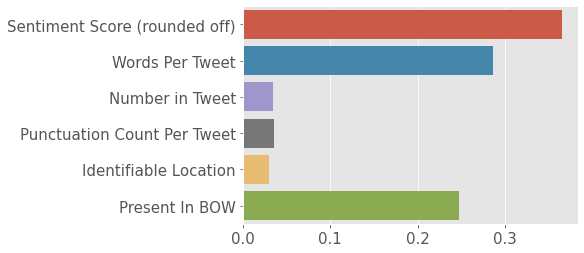

In [31]:
sns.barplot(x=rfc.feature_importances_, y=cols_to_train)

**Observations**

From this experiment, Sentiment, Words Per Tweet and IN BOW have stronger effect on the predictions. Therefore, I will be using them in the next set of tests.

## Testing Scaling Strategies

In [32]:
list_scalers = [
    StandardScaler(),
    QuantileTransformer(),
    MinMaxScaler(),
    MaxAbsScaler(),
    RobustScaler()
]

cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET, IN_BOW]
cols_to_scale = [WORDS_PER_TWEET]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)

for scaler in list_scalers:
    print(scaler)
    ct = ColumnTransformer(
        [("scaler", scaler, cols_to_scale),
         ("count_vec", CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
        remainder='passthrough')

    ct.fit(X_train)
    X_train_sparse = ct.transform(X_train)
    X_test_sparse = ct.transform(X_test)
    log_reg = LogisticRegression()
    log_reg.fit(X_train_sparse, y_train)
    test_prediction = log_reg.predict(X_test_sparse)
    training_prediction = log_reg.predict(X_train_sparse)
    print_classification_metrics(y_train, training_prediction, y_test,
                                 test_prediction)
    print('-------------------------')

StandardScaler()
Training Accuracy:  0.9875205254515599
Training f1-score:  0.9853902345251827
Accuracy:  0.8003939592908733
Precision:  0.7928692699490663
Recall:  0.7195685670261941
f1-score:  0.7544426494345718
-------------------------
QuantileTransformer()
Training Accuracy:  0.9875205254515599
Training f1-score:  0.9853846153846155
Accuracy:  0.799080761654629
Precision:  0.7931623931623931
Recall:  0.7149460708782742
f1-score:  0.7520259319286872
-------------------------
MinMaxScaler()
Training Accuracy:  0.9875205254515599
Training f1-score:  0.9853902345251827
Accuracy:  0.7984241628365069
Precision:  0.7928082191780822
Recall:  0.7134052388289677
f1-score:  0.7510137875101379
-------------------------
MaxAbsScaler()
Training Accuracy:  0.9875205254515599
Training f1-score:  0.9853902345251827
Accuracy:  0.799080761654629
Precision:  0.7931623931623931
Recall:  0.7149460708782742
f1-score:  0.7520259319286872
-------------------------
RobustScaler()
Training Accuracy:  0.9875

**Observations**

The standard scaler is performing the best considering the f1-score of the hold-out test data.

## Testing Multiple Machine Learning Models

In [33]:
cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET, IN_BOW]
cols_to_scale = [WORDS_PER_TWEET]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.2,
                                                    random_state=42)
ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ("count_vec", CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
    remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [34]:
models_list = [LogisticRegression(),
               SVC(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier()]

In [35]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 1.50 s.
Completed LogisticRegression model's performance assessment.
Training SVC model...
Completed SVC model training.
Time elapsed: 16.87 s.
Completed SVC model's performance assessment.
Training KNeighborsClassifier model...
Completed KNeighborsClassifier model training.
Time elapsed: 0.00 s.
Completed KNeighborsClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 6.53 s.
Completed DecisionTreeClassifier model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 42.35 s.
Completed RandomForestClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 9.19 s.
Completed GradientBoostingClassifier model's performance assessment.

In [36]:
DF_PERF_METRICS

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs)
0,LogisticRegression,0.987521,0.800394,0.792869,0.719569,0.754443,1.50
1,SVC,0.957471,0.793828,0.837022,0.640986,0.726003,16.87
2,KNeighborsClassifier,0.783415,0.714380,0.854305,0.397535,0.542587,0.00
3,DecisionTreeClassifier,0.991461,0.746553,0.711755,0.681048,0.696063,6.53
4,RandomForestClassifier,0.991461,0.782666,0.816733,0.631741,0.712424,42.35
5,GradientBoostingClassifier,0.772250,0.742613,0.762781,0.574730,0.655536,9.19


# HyperParameter Tuning for Model Improvement

Proceeding onto tuning logistic regression since it has the best F1 score so far. I start with the a sparse set of values for max_iter and C.

I am using the features  **ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET, IN_BOW**

For  **WORDS_PER_TWEET**  is scaled using Standard Scaler and  **ALL_TEXT_JOINED**  is vectorized using CountVectorizer.


In [37]:
# Execute the data prep pipeline

cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET, IN_BOW]
cols_to_scale = [WORDS_PER_TWEET]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    test_size=0.1,
                                                    random_state=42)
ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ("count_vec", CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
    remainder='passthrough')

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

## Attempt 1

In [38]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...........C=0.1, max_iter=100; f1: (test=0.746) total time=   0.5s
[CV 2/5] END ...........C=0.1, max_iter=100; f1: (test=0.694) total time=   0.7s
[CV 3/5] END ...........C=0.1, max_iter=100; f1: (test=0.753) total time=   0.7s
[CV 4/5] END ...........C=0.1, max_iter=100; f1: (test=0.730) total time=   0.6s
[CV 5/5] END ...........C=0.1, max_iter=100; f1: (test=0.697) total time=   0.7s
[CV 1/5] END ...........C=0.1, max_iter=200; f1: (test=0.746) total time=   0.6s
[CV 2/5] END ...........C=0.1, max_iter=200; f1: (test=0.694) total time=   0.7s
[CV 3/5] END ...........C=0.1, max_iter=200; f1: (test=0.753) total time=   0.7s
[CV 4/5] END ...........C=0.1, max_iter=200; f1: (test=0.730) total time=   0.7s
[CV 5/5] END ...........C=0.1, max_iter=200; f1: (test=0.697) total time=   0.7s
[CV 1/5] END ...........C=0.1, max_iter=500; f1: (test=0.746) total time=   0.7s
[CV 2/5] END ...........C=0.1, max_iter=500; f1

[CV 2/5] END ...........C=100, max_iter=100; f1: (test=0.748) total time=   1.8s
[CV 3/5] END ...........C=100, max_iter=100; f1: (test=0.753) total time=   1.8s
[CV 4/5] END ...........C=100, max_iter=100; f1: (test=0.735) total time=   1.8s
[CV 5/5] END ...........C=100, max_iter=100; f1: (test=0.718) total time=   1.8s
[CV 1/5] END ...........C=100, max_iter=200; f1: (test=0.765) total time=   3.5s
[CV 2/5] END ...........C=100, max_iter=200; f1: (test=0.750) total time=   3.5s
[CV 3/5] END ...........C=100, max_iter=200; f1: (test=0.759) total time=   3.5s
[CV 4/5] END ...........C=100, max_iter=200; f1: (test=0.738) total time=   3.5s
[CV 5/5] END ...........C=100, max_iter=200; f1: (test=0.720) total time=   3.5s
[CV 1/5] END ...........C=100, max_iter=500; f1: (test=0.765) total time=   4.9s
[CV 2/5] END ...........C=100, max_iter=500; f1: (test=0.748) total time=   5.1s
[CV 3/5] END ...........C=100, max_iter=500; f1: (test=0.759) total time=   5.4s
[CV 4/5] END ...........C=10

In [39]:
model_1 = grid_result.best_estimator_
y_pred_attempt_1 = model_1.predict(X_test_sparse)
training_prediction = model_1.predict(X_train_sparse)
print_classification_metrics(y_train, training_prediction, y_test, y_pred_attempt_1)

Training Accuracy:  0.9900744416873449
Training f1-score:  0.9883481836874571
Accuracy:  0.7860892388451444
Precision:  0.7952218430034129
Recall:  0.6934523809523809
f1-score:  0.7408585055643879


In [40]:
grid_result.best_params_

{'C': 10, 'max_iter': 100}

## Atempt 2

In this attempt, I have narrowed down the grid values where the middle value is the previous best hyperparameter values.

In [41]:
max_iter = [50, 100, 150]
C = [5, 10, 15]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..............C=5, max_iter=50; f1: (test=0.759) total time=   1.0s
[CV 2/5] END ..............C=5, max_iter=50; f1: (test=0.751) total time=   1.0s
[CV 3/5] END ..............C=5, max_iter=50; f1: (test=0.758) total time=   1.0s
[CV 4/5] END ..............C=5, max_iter=50; f1: (test=0.743) total time=   1.0s
[CV 5/5] END ..............C=5, max_iter=50; f1: (test=0.730) total time=   1.0s
[CV 1/5] END .............C=5, max_iter=100; f1: (test=0.759) total time=   1.9s
[CV 2/5] END .............C=5, max_iter=100; f1: (test=0.752) total time=   1.7s
[CV 3/5] END .............C=5, max_iter=100; f1: (test=0.759) total time=   1.8s
[CV 4/5] END .............C=5, max_iter=100; f1: (test=0.742) total time=   1.8s
[CV 5/5] END .............C=5, max_iter=100; f1: (test=0.730) total time=   1.8s
[CV 1/5] END .............C=5, max_iter=150; f1: (test=0.759) total time=   2.1s
[CV 2/5] END .............C=5, max_iter=150; f1: 

In [42]:
model_2 = grid_result.best_estimator_
y_pred_attempt_2 = model_2.predict(X_test_sparse)
training_prediction = model_2.predict(X_train_sparse)
print_classification_metrics(y_train, training_prediction, y_test, y_pred_attempt_2)

Training Accuracy:  0.9900744416873449
Training f1-score:  0.9883481836874571
Accuracy:  0.7860892388451444
Precision:  0.7952218430034129
Recall:  0.6934523809523809
f1-score:  0.7408585055643879


In [43]:
grid_result.best_params_

{'C': 10, 'max_iter': 100}

There is a slight improvement in the F1 score.

## Attempt 3

In this attempt, I tried different combinations of penalty, solver and fit_intercept to check if they could predict better.

In [51]:
penalty = ['elasticnet', 'l1', 'l2']
solver = ['saga', 'liblinear', 'lbfgs']
max_iter = [75, 100, 125]
C = [5, 10, 15]
fit_intercept = [True, False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 5/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 1/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=liblinear; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=liblinear; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=5, fit_intercept=True, max_iter=75, penalty=elasticnet, solver=liblinear; f1: (test=na

[CV 1/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.766) total time=   0.2s
[CV 2/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.747) total time=   0.2s
[CV 3/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.764) total time=   0.2s
[CV 4/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.739) total time=   0.2s
[CV 5/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.730) total time=   0.2s
[CV 1/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear; f1: (test=0.761) total time=   0.0s
[CV 2/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear; f1: (test=0.743) total time=   0.0s
[CV 3/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear; f1: (test=0.757) total time=   0.0s
[CV 4/5] END C=5, fit_intercept=True, max_iter=100, penalty=l2, solver=liblinear;

[CV 1/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=saga; f1: (test=0.761) total time=  15.3s
[CV 2/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=saga; f1: (test=0.736) total time=  14.9s
[CV 3/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=saga; f1: (test=0.747) total time=  15.1s
[CV 4/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=saga; f1: (test=0.739) total time=  15.2s
[CV 5/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=saga; f1: (test=0.721) total time=  14.6s
[CV 1/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.745) total time=   0.0s
[CV 2/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.738) total time=   0.0s
[CV 3/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.737) total time=   0.0s
[CV 4/5] END C=5, fit_intercept=False, max_iter=75, penalty=l1, solver=liblinear;

[CV 2/5] END C=5, fit_intercept=False, max_iter=100, penalty=l2, solver=lbfgs; f1: (test=0.732) total time=   0.5s
[CV 3/5] END C=5, fit_intercept=False, max_iter=100, penalty=l2, solver=lbfgs; f1: (test=0.742) total time=   0.6s
[CV 4/5] END C=5, fit_intercept=False, max_iter=100, penalty=l2, solver=lbfgs; f1: (test=0.726) total time=   0.5s
[CV 5/5] END C=5, fit_intercept=False, max_iter=100, penalty=l2, solver=lbfgs; f1: (test=0.715) total time=   0.5s
[CV 1/5] END C=5, fit_intercept=False, max_iter=125, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=5, fit_intercept=False, max_iter=125, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=5, fit_intercept=False, max_iter=125, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=5, fit_intercept=False, max_iter=125, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 5/5] END C=5, fit_intercept=False, max_iter=125, penalty

[CV 3/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.738) total time=   0.0s
[CV 4/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.729) total time=   0.0s
[CV 5/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=liblinear; f1: (test=0.714) total time=   0.0s
[CV 1/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 5/5] END C=10, fit_intercept=True, max_iter=75, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 1/5] END C=10, fit_intercept=True, max_iter=75, penalty=l2, solver=saga; f1: (test

[CV 1/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=saga; f1: (test=0.770) total time=  32.8s
[CV 2/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=saga; f1: (test=0.745) total time=  29.8s
[CV 3/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=saga; f1: (test=0.759) total time=  30.4s
[CV 4/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=saga; f1: (test=0.742) total time=  30.1s
[CV 5/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=saga; f1: (test=0.725) total time=  29.2s
[CV 1/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.751) total time=   0.0s
[CV 2/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.738) total time=   0.0s
[CV 3/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.736) total time=   0.0s
[CV 4/5] END C=10, fit_intercept=True, max_iter=125, penalty=l1, solver=l

[CV 1/5] END C=10, fit_intercept=False, max_iter=75, penalty=l2, solver=lbfgs; f1: (test=0.759) total time=   0.6s
[CV 2/5] END C=10, fit_intercept=False, max_iter=75, penalty=l2, solver=lbfgs; f1: (test=0.731) total time=   0.6s
[CV 3/5] END C=10, fit_intercept=False, max_iter=75, penalty=l2, solver=lbfgs; f1: (test=0.739) total time=   0.6s
[CV 4/5] END C=10, fit_intercept=False, max_iter=75, penalty=l2, solver=lbfgs; f1: (test=0.726) total time=   0.6s
[CV 5/5] END C=10, fit_intercept=False, max_iter=75, penalty=l2, solver=lbfgs; f1: (test=0.715) total time=   0.5s
[CV 1/5] END C=10, fit_intercept=False, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=10, fit_intercept=False, max_iter=100, penalty=

[CV 5/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=saga; f1: (test=0.719) total time=  30.4s
[CV 1/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.748) total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.730) total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.735) total time=   0.0s
[CV 4/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.721) total time=   0.0s
[CV 5/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=liblinear; f1: (test=0.714) total time=   0.0s
[CV 1/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=10, fit_intercept=False, max_iter=125, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=10, fit_intercept=False, max_iter=125, pen

[CV 1/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.764) total time=  35.0s
[CV 2/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.742) total time=  34.5s
[CV 3/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.761) total time=  34.9s
[CV 4/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.748) total time=  34.4s
[CV 5/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.728) total time=  33.5s
[CV 1/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.754) total time=   0.0s
[CV 2/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.732) total time=   0.0s
[CV 3/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.734) total time=   0.0s
[CV 4/5] END C=15, fit_intercept=True, max_iter=100, penalty=l1, solver=l

[CV 1/5] END C=15, fit_intercept=True, max_iter=125, penalty=l2, solver=lbfgs; f1: (test=0.757) total time=   1.0s
[CV 2/5] END C=15, fit_intercept=True, max_iter=125, penalty=l2, solver=lbfgs; f1: (test=0.741) total time=   0.9s
[CV 3/5] END C=15, fit_intercept=True, max_iter=125, penalty=l2, solver=lbfgs; f1: (test=0.755) total time=   1.0s
[CV 4/5] END C=15, fit_intercept=True, max_iter=125, penalty=l2, solver=lbfgs; f1: (test=0.736) total time=   1.0s
[CV 5/5] END C=15, fit_intercept=True, max_iter=125, penalty=l2, solver=lbfgs; f1: (test=0.725) total time=   1.0s
[CV 1/5] END C=15, fit_intercept=False, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=15, fit_intercept=False, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=15, fit_intercept=False, max_iter=75, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=15, fit_intercept=False, max_iter=75, penalty=elas

[CV 2/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.731) total time=   0.0s
[CV 3/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.729) total time=   0.0s
[CV 4/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.722) total time=   0.0s
[CV 5/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=liblinear; f1: (test=0.717) total time=   0.0s
[CV 1/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1, solver=lbfgs; f1: (test=nan) total time=   0.0s
[CV 5/5] END C=15, fit_intercept=False, max_iter=100, penalty=l1

In [52]:
model_3 = grid_result.best_estimator_
y_pred_attempt_3 = model_3.predict(X_test_sparse)
training_prediction = model_3.predict(X_train_sparse)
print_classification_metrics(y_train, training_prediction, y_test, y_pred_attempt_3)

Training Accuracy:  0.9900744416873449
Training f1-score:  0.988352175402535
Accuracy:  0.7769028871391076
Precision:  0.7804054054054054
Recall:  0.6875
f1-score:  0.7310126582278482


In [53]:
grid_result.best_params_

{'C': 10,
 'fit_intercept': True,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'}

Again, there is slight improvment in the model performance.

# Results

The best results were with default hyperparameters of Logistic Regression. The features included the selected features, where words_per_tweet was scaled using StandardScalar, and the the text data vectorized using CountVectorizer.

On tuning the algorithm, the best results are obtained using - 
 
``'C': 10,
 'fit_intercept': False,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga'``
 

# Final Model Training

In [ ]:
cols_to_train = [ALL_TEXT_JOINED, SENTIMENT_ROUND, WORDS_PER_TWEET, IN_BOW]
cols_to_scale = [WORDS_PER_TWEET]

X, y = df_train[cols_to_train], df_train[TARGET].values

ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ("count_vec", CountVectorizer(ngram_range=(1, 2)), ALL_TEXT_JOINED)],
    remainder='passthrough')

ct.fit(X)
X_sparse = ct.transform(X)

final_model = LogisticRegression(C=10,
                                 max_iter=100,
                                 fit_intercept=False,
                                 penalty='l1',
                                 solver='saga')

final_model.fit(X_sparse, y)

In [ ]:
print('Training Accuracy: ', round(final_model.score(X_sparse, y), 2))

In [ ]:
df_test_sparse = ct.transform(df_test[cols_to_train])
predict_challenge_test_data(final_model, df_test_sparse, 'Predictions/final_predictions.csv')

## Kaggle Results